<a href="https://colab.research.google.com/github/kvbiii/Stock-Price-Prediction/blob/main/LSTM_stock_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Introduction**
Forecasting stock prices plays an important role in setting a trading strategy or determining the appropriate timing for buying or selling a stock. In this project, I used a model, called LSTM - long short-term memory model. 

#**Importing the libraries**

In [91]:
!pip install yfinance
import yfinance as yf
import pandas as pd 
import numpy as np  
import datetime as dt
import pandas_datareader as web
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import math 
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Company that we want to see prediction for

In [92]:
company = 'AAPL'
prediction_days = 60

Starting and ending dates of the data which will be imported

In [93]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime.now()

Importing data

In [94]:
df = yf.download(company, start, end)

[*********************100%***********************]  1 of 1 completed


Creating a new data frame with only 'Close' prices

In [95]:
data = df.filter(['Close'])

Converting data frame to array

In [96]:
dataset = data.values

Scaling the data

In [97]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset)
training_data_len = math.ceil(len(dataset) * 0.95)

Creating scaled training data

In [98]:
train_data = scaled_data[0:training_data_len , :]

Spliting the data into x_train and y_train

In [99]:
x_train = []
y_train = []
for i in range(prediction_days, len(train_data)):
    x_train.append(train_data[i-prediction_days:i, 0])
    y_train.append(train_data[i, 0])

Converting x_train and y_train to arrays

In [100]:
x_train, y_train = np.array(x_train), np.array(y_train)

Reshaping x_train

In [101]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# **Creating the LSTM model**

In [102]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

Compiling the model

In [103]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

Training the model

In [104]:
model.fit(x_train, y_train, batch_size = 1, epochs = 1)

5306/5306 [==============================] - 174s 32ms/step - loss: 0.0057


Creating testing data

In [105]:
test_data = scaled_data[training_data_len - prediction_days: , :]

Creating x_test and y_test

In [106]:
x_test = []
y_test = dataset[training_data_len:]
for i in range(prediction_days, len(test_data)):
    x_test.append(test_data[i-prediction_days:i, 0])

Converting x_test to array

In [107]:
x_test = np.array(x_test)

Reshaping x_test

In [108]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# **Getting the model predictions**

In [109]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# **Creating new data frame to see what price the model will predict for future**

In [110]:
test_start = dt.datetime(2015, 1, 1)
test_end = dt.datetime.now()
new_df = yf.download(company, test_start, test_end)
new_data = new_df.filter(['Close'])

[*********************100%***********************]  1 of 1 completed


Creating model predictions for future

In [111]:
forecast_out = int(math.ceil(0.01*len(new_data)))
X_lately = x_test[-forecast_out:]
y_predict = model.predict(X_lately)
y_predict = scaler.inverse_transform(y_predict)

Getting the last 60 days and converting that to new data frame

In [112]:
last_60_days = new_data[-prediction_days:].values

Scaling the data

In [113]:
last_60_days_scaled = scaler.transform(last_60_days)

New X_test

In [114]:
X_test = []
X_test.append(last_60_days_scaled)

Converting X_test to array

In [115]:
X_test = np.array(X_test)

Reshaping X_test

In [116]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Getting the root mean squared error (RMSE) which is the standard deviation of the prediction errors

In [117]:
print('Mean squared error is: {}'.format(mean_squared_error(y_test, predictions)))

Mean squared error is: 63.34734052043996


Creating the value which is a correlation between real price and our model predicted price

In [118]:
corr_price, p = stats.pearsonr(valid['Close'].values, valid['Predictions'].values)
print("Correlation between actual price and predicted by our model price is: {}".format(corr_price))

Correlation between actual price and predicted by our model price is: 0.9739902754267097


Recreating my arrays to create summarizing data frame

In [119]:
y_test = y_test.flatten().tolist()
predictions = predictions.flatten().tolist()
columns =  ['Close_actual', 'Close_pred']
df_pred_LSTM = pd.DataFrame(list(zip(y_test, predictions)), columns = columns)
df_pred_LSTM['diff'] = df_pred_LSTM.Close_actual.values - df_pred_LSTM.Close_pred.values
df_pred_LSTM['perc_diff'] = ((df_pred_LSTM['diff']) / (df_pred_LSTM['Close_pred']))*100
print(df_pred_LSTM)

     Close_actual  Close_pred      diff  perc_diff
0      132.539993  130.906937  1.633057   1.247494
1      127.849998  130.542847 -2.692848  -2.062808
2      128.100006  129.080124 -0.980118  -0.759310
3      129.740005  127.809456  1.930550   1.510490
4      130.210007  127.388191  2.821815   2.215131
..            ...         ...       ...        ...
277    148.710007  143.200623  5.509384   3.847319
278    147.960007  143.094360  4.865646   3.400306
279    142.639999  143.013992 -0.373993  -0.261508
280    137.130005  141.606979 -4.476974  -3.161549
281    131.880005  138.810654 -6.930649  -4.992880

[282 rows x 4 columns]


Creating DataFrame of final version

In [120]:
a = []
for i in range(df_pred_LSTM.index[-1], df_pred_LSTM.index[-1]+forecast_out):
    a.append(i)
y_predict = y_predict.flatten().tolist()
abc = pd.DataFrame({'Future': y_predict}, index = a)
df_final = pd.concat([df_pred_LSTM, abc], axis=1)

Final result summary

In [121]:
print('Model predicted for today close: {}, current price is: {}'.format(round(df_pred_LSTM['Close_pred'].iat[-1], 2), round(df_pred_LSTM['Close_actual'].iat[-1], 2)))

Model predicted for today close: 138.81, current price is: 131.88


# **Visualizing the data**

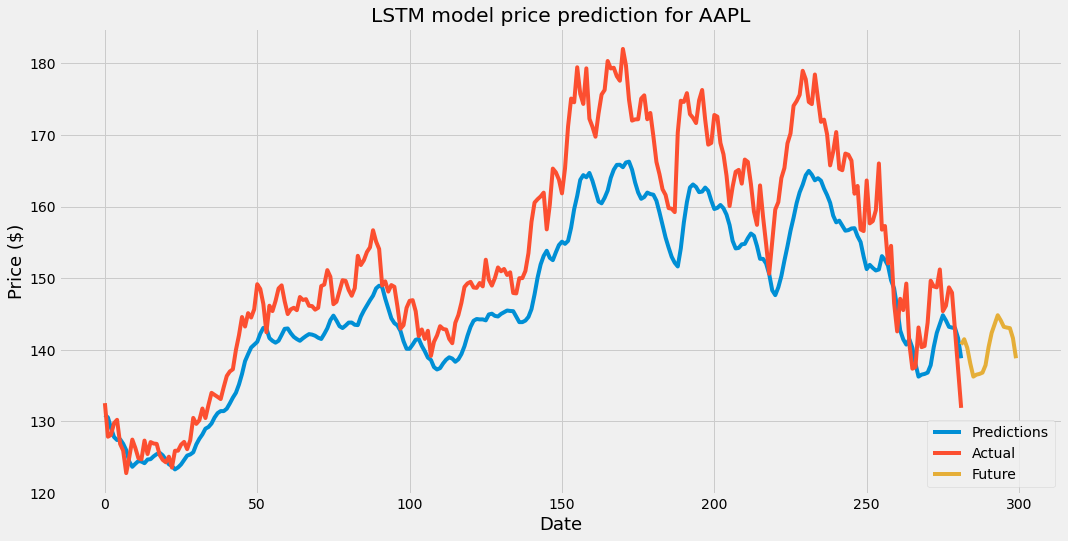

In [122]:
plt.figure(figsize=(16, 8))
plt.plot(df_final.Close_pred)
plt.plot(df_final.Close_actual)
plt.plot(df_final.Future)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price ($)', fontsize = 18)
plt.legend(['Predictions',  'Actual', 'Future'], loc='lower right')
plt.title('LSTM model price prediction for {}'.format(company))
plt.show()

In [123]:
print(df_final)

     Close_actual  Close_pred      diff  perc_diff      Future
0      132.539993  130.906937  1.633057   1.247494         NaN
1      127.849998  130.542847 -2.692848  -2.062808         NaN
2      128.100006  129.080124 -0.980118  -0.759310         NaN
3      129.740005  127.809456  1.930550   1.510490         NaN
4      130.210007  127.388191  2.821815   2.215131         NaN
..            ...         ...       ...        ...         ...
295           NaN         NaN       NaN        NaN  143.200623
296           NaN         NaN       NaN        NaN  143.094360
297           NaN         NaN       NaN        NaN  143.013992
298           NaN         NaN       NaN        NaN  141.606979
299           NaN         NaN       NaN        NaN  138.810654

[300 rows x 5 columns]
